In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')
results = pd.read_csv('results.csv')
races=pd.read_csv('races.csv')
imp_df = [constructors, drivers,  results,races]

for df in imp_df:
    df.replace('\\N', np.nan, inplace=True)
    print(df.dtypes)

races.drop(columns=['fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],inplace=True)


constructorId      int64
constructorRef    object
name              object
nationality       object
url               object
dtype: object
driverId        int64
driverRef      object
number         object
code           object
forename       object
surname        object
dob            object
nationality    object
url            object
dtype: object
resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object
raceId          int64
year            int64
round           int64
circuitId       int64
name           object
date           object
time           ob

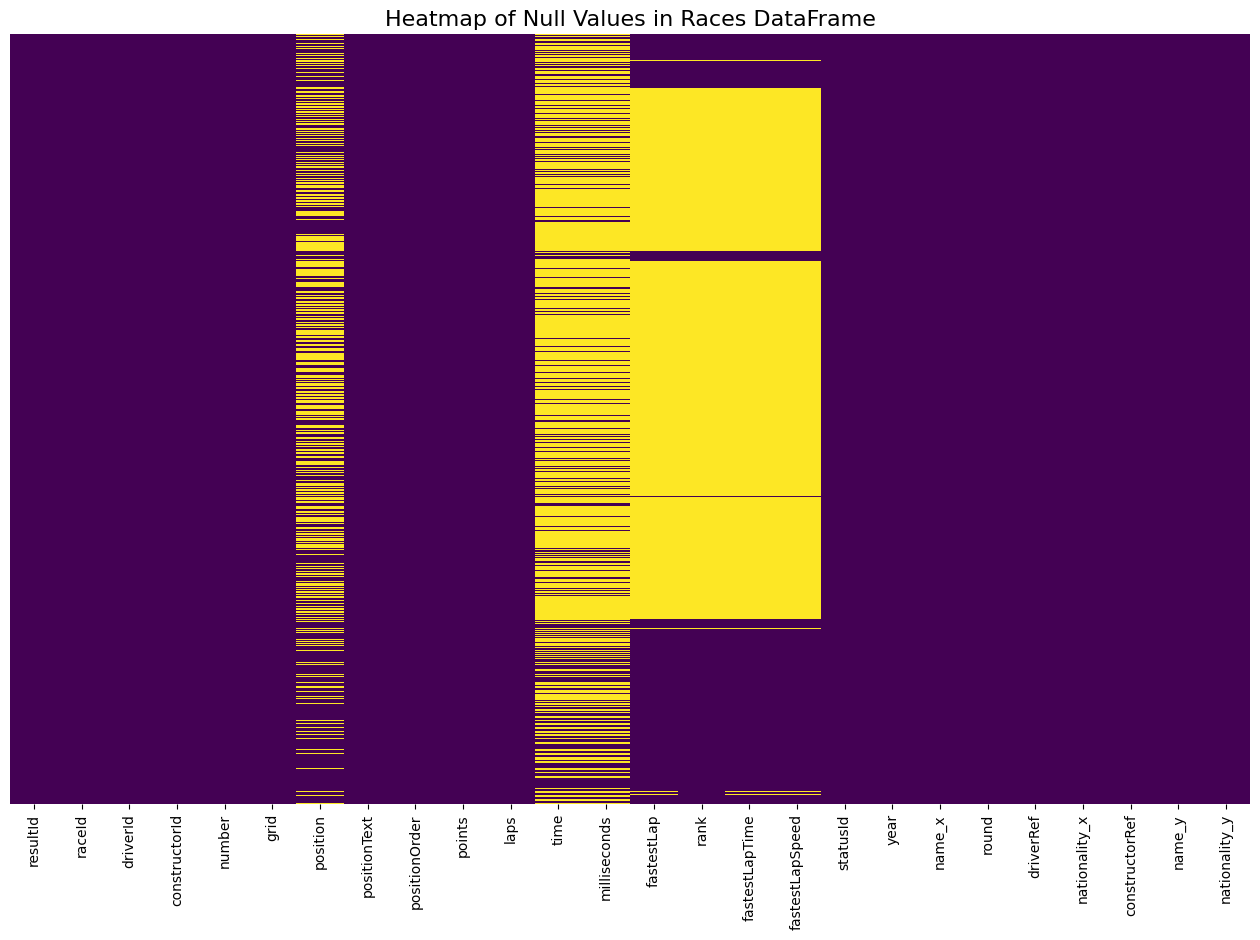

In [21]:
df=pd.merge(results,races[['raceId','year','name','round']],on='raceId',how='left')
df=pd.merge(df,drivers[['driverId','driverRef','nationality']],on='driverId',how='left')
df=pd.merge(df,constructors[['constructorId','constructorRef','name','nationality']],on='constructorId',how='left')
plt.figure(figsize=(16, 10))

# Create a heatmap to visualize null values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)

# Add title and display the heatmap
plt.title('Heatmap of Null Values in Races DataFrame', fontsize=16)
plt.show()



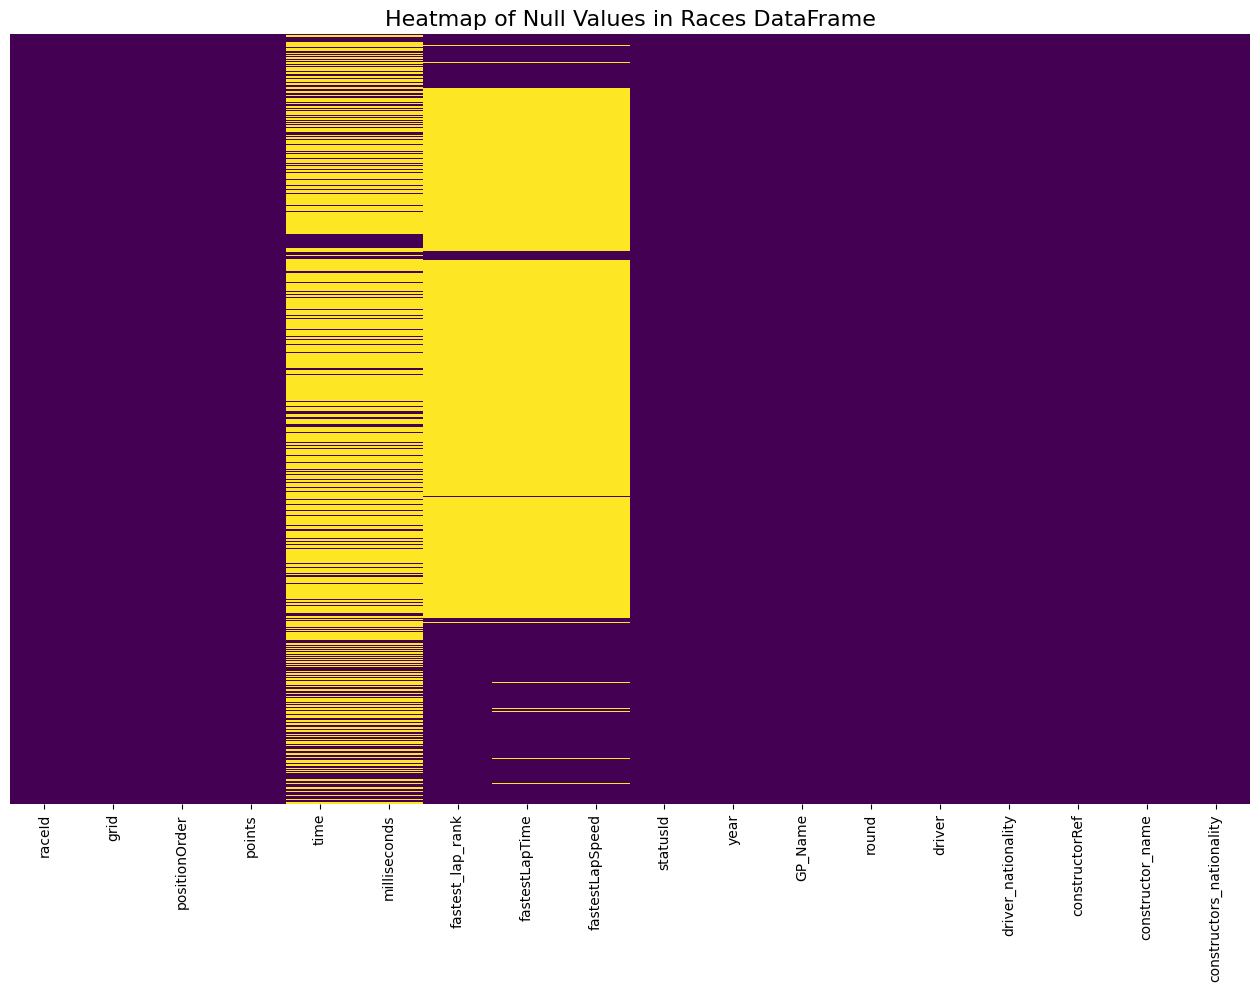

In [22]:
df.drop(columns=['number','position','positionText','laps','fastestLap','resultId','driverId','constructorId'],axis=1,inplace=True)

df.rename(columns={'rank':'fastest_lap_rank','name_x':'GP_Name','nationality_x':'driver_nationality','name_y':'constructor_name','nationality_y':'constructors_nationality','driverRef':'driver'},inplace=True)
df['fastest_lap_rank'] = pd.to_numeric(df['fastest_lap_rank'], errors='coerce').astype('Int64')
plt.figure(figsize=(16, 10))

# Create a heatmap to visualize null values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)

plt.title('Heatmap of Null Values in Races DataFrame', fontsize=16)
plt.show()

In [23]:
print(df['driver'].head(10))

0      hamilton
1      heidfeld
2       rosberg
3        alonso
4    kovalainen
5      nakajima
6      bourdais
7     raikkonen
8        kubica
9         glock
Name: driver, dtype: object


In [24]:
driver_1 = 'hamilton'
driver_2 = 'max_verstappen'

df_h2h = df[df['driver'].isin([driver_1, driver_2])].copy()
print(df_h2h.head(10))


     raceId  grid  positionOrder  points         time milliseconds  \
0        18     1              1    10.0  1:34:50.616      5690616   
26       19     9              5     4.0      +46.548      5525103   
56       20     3             13     0.0          NaN          NaN   
68       21     5              3     6.0       +4.187      5903238   
89       22     3              2     8.0       +3.779      5213230   
108      23     3              1    10.0  2:00:42.742      7242742   
146      24     1             19     0.0          NaN          NaN   
157      25    13             10     0.0      +54.538      5564783   
168      26     4              1    10.0  1:39:09.440      5949440   
188      27     1              1    10.0  1:31:20.874      5480874   

     fastest_lap_rank fastestLapTime fastestLapSpeed  statusId  year  \
0                   2       1:27.452         218.300         1  2008   
26                  3       1:35.462         209.033         1  2008   
56           

In [25]:

h2h_stats = df_h2h.groupby('driver').agg(
    total_races=('raceId', 'nunique'),
    total_wins=('positionOrder', lambda x: (x == 1).sum()),
    win_percentage=('positionOrder', lambda x: round((x == 1).mean() * 100, 2)),
    total_podiums=('positionOrder', lambda x: (x <= 3).sum()),
    podium_percentage=('positionOrder', lambda x: round((x <= 3).mean() * 100, 2)),
    avg_finish=('positionOrder', 'mean'),
    avg_qualifying=('grid', 'mean'),
    total_points=('points', 'sum'),
    avg_points_per_race=('points', 'mean'),
    top_5_finishes=('positionOrder', lambda x: (x <= 5).sum()),
    top_10_finishes=('positionOrder', lambda x: (x <= 10).sum()),
    finished_races=('statusId', lambda x: (x == 1).sum()),
    fastest_laps=('fastest_lap_rank', lambda x: (x == 1).sum()),
    pole_positions=('grid', lambda x: (x == 1).sum())
).reset_index()

print(h2h_stats)


           driver  total_races  total_wins  win_percentage  total_podiums  \
0        hamilton          356         105           29.49            202   
1  max_verstappen          209          63           30.14            112   

   podium_percentage  avg_finish  avg_qualifying  total_points  \
0              56.74    5.019663        4.300562        4820.5   
1              53.59    5.645933        4.956938        2912.5   

   avg_points_per_race  top_5_finishes  top_10_finishes  finished_races  \
0            13.540730             261              312             312   
1            13.935407             144              172             170   

   fastest_laps  pole_positions  
0            66             104  
1            33              40  


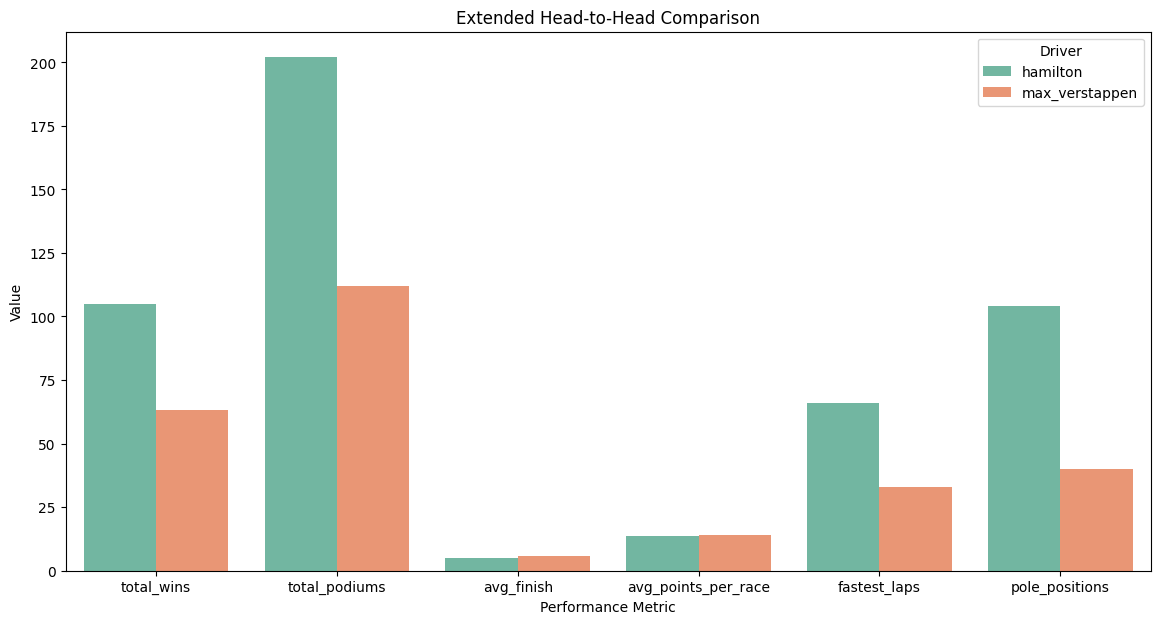

In [26]:
h2h_melted = h2h_stats.melt(id_vars='driver', var_name='metric', value_name='value')

key_metrics = ['total_wins', 'total_podiums', 'avg_finish', 'dnf_count',
               'fastest_laps', 'pole_positions', 'avg_points_per_race']

h2h_filtered = h2h_melted[h2h_melted['metric'].isin(key_metrics)]

plt.figure(figsize=(14, 7))
sns.barplot(data=h2h_filtered, x='metric', y='value', hue='driver', palette='Set2')
plt.title('Extended Head-to-Head Comparison')
plt.xlabel('Performance Metric')
plt.ylabel('Value')
plt.legend(title='Driver')
plt.show()
